# Mario map
### Trying to auto generate mario-like maps

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import random
from simpledbf import Dbf5

In [2]:
map_tif_path = glob.glob("map_data/gm_lc_v3/*.tif")
im_full = [Image.open(path) for path in map_tif_path]

/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (933120000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [3]:
scale_1 = 2
im_full_scaled = [im.resize((int(im.size[0]/scale_1),int(im.size[1]/scale_1)),
                                resample = PIL.Image.NEAREST) for im in im_full]

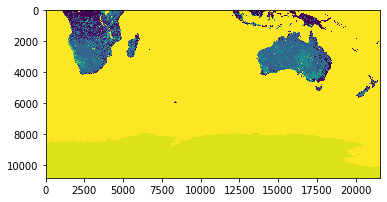

In [4]:
plt.imshow(im_full_scaled[3])
plt.show()

In [5]:
im_full_scaled

[<PIL.Image.Image image mode=L size=21600x10800 at 0x1050D94A8>,
 <PIL.Image.Image image mode=L size=21600x10800 at 0x1050D9390>,
 <PIL.Image.Image image mode=L size=21600x10800 at 0x1050D9320>,
 <PIL.Image.Image image mode=L size=21600x10800 at 0x10501E668>]

In [6]:
[im_full_scaled[i].size for i in range(4)]

[(21600, 10800), (21600, 10800), (21600, 10800), (21600, 10800)]

In [7]:
im_full_scaled[0].info

{'compression': 'tiff_lzw', 'dpi': (1, 1), 'resolution': (1, 1)}

In [8]:
im = Image.new("L", (im_full_scaled[0].size[0]*2,im_full_scaled[0].size[1]*2))
width = im_full_scaled[1].size[0]
height = im_full_scaled[1].size[1]
im.paste(im_full_scaled[0],(0,0))
im.paste(im_full_scaled[1],(width,0))
im.paste(im_full_scaled[2],(0,height))
im.paste(im_full_scaled[3],(width,height))
im_master = im

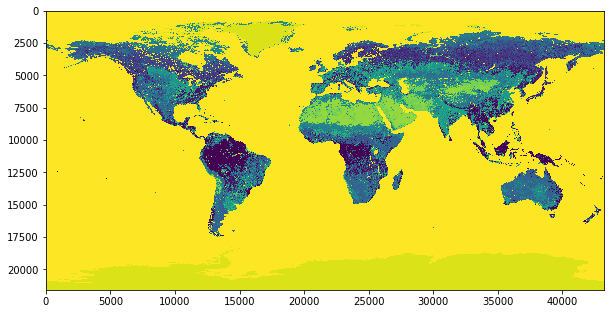

In [9]:
fig = plt.figure(figsize = (10,20))
plt.imshow(im_master, aspect = "equal")
plt.show()

19800 18000 23400 15600


/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (140400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


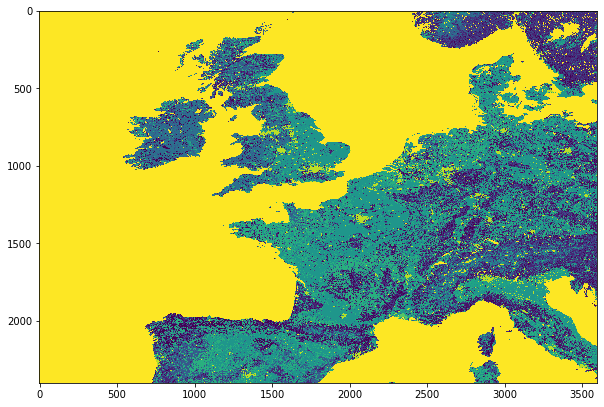

In [10]:
fig = plt.figure(figsize = (10,20))

lat_top = 60
lat_bottom = 40
lon_left = -15
lon_right = 15

w, h = im_master.size[0], im_master.size[1]

l = int((lon_left + 180) * w /360)
u = int((lat_top + 90)*h/180)
r = int((lon_right + 180) * w /360)
d = int((lat_bottom + 90)*h/180)

print(l,u,r,d)
im = im_master.crop((l, h - u, r, h - d))


plt.imshow(im, aspect = "equal")
plt.show()

In [53]:
data = np.array(im)
data = np.flip(data, axis = 1)
data = data.swapaxes(0,1)
data = np.flip(data, axis = 0)

### Now to get mario sprites

sprites/zanzio.png


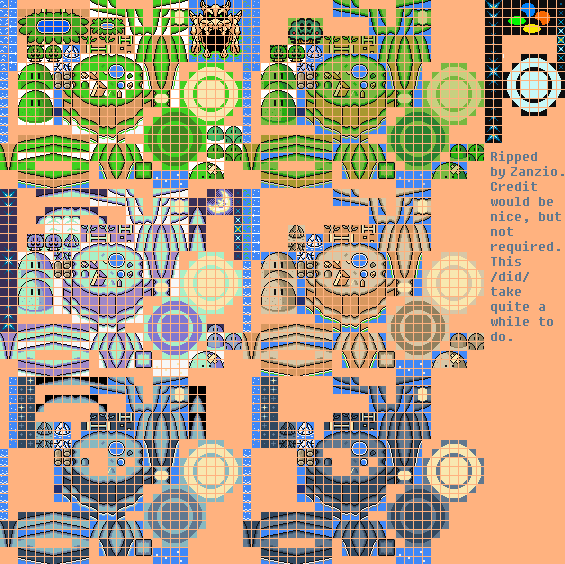

In [177]:
tile_sheet_path = glob.glob("sprites/zanzio.png")[0]
print(tile_sheet_path)
tile_sheet = Image.open(tile_sheet_path)
tile_sheet

sprites/zanzio.png


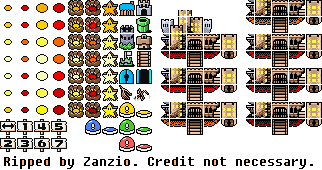

In [178]:
level_sheet_path = glob.glob("sprites/levela.png")[0]
print(tile_sheet_path)
level_sheet = Image.open(level_sheet_path)
level_sheet

In [179]:
def get_sprite_small(x, y, tile_sheet = tile_sheet):
    l = x * 9
    u = y * 9
    r = l + 8
    d = u + 8
    return tile_sheet.crop((l,u,r,d))

def get_sprite(x, y, w = 1, h = 1, tile_sheet = tile_sheet):
    if w == 1 and h == 1:
        return get_sprite_small(x,y, tile_sheet)
    im = Image.new("RGBA", (w * 8, h * 8))
    for i in range(w):
        for j in range(h):
            s = get_sprite_small(x + i,y + j,tile_sheet)
            im.paste(s, (i*8,j*8))
    return im

def get_sprite_level(x,y):
    l = x*17
    u = y*17
    r = l + 16
    d = u + 16
    return level_sheet.crop((l,u,r,d))

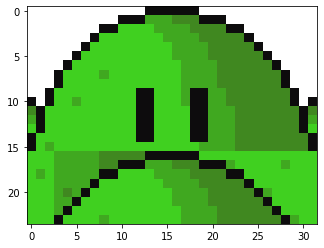

In [180]:
plt.imshow(get_sprite(2,7, h = 3, w = 4))
plt.show()

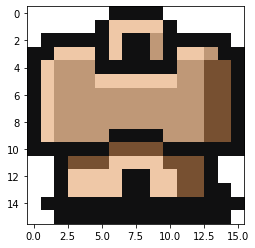

In [181]:
plt.imshow(get_sprite_level(8,2))
plt.show()

### Nice: sprites are loaded
### Now to NOT USE PYGAME
#### Using Image class as a canvas instead....

In [182]:
tiles_x = 100
tiles_y = int(tiles_x * im.size[1] / im.size[0])
canvas = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
print(tiles_y)

66


In [183]:
canvas.paste((68,139,244),(0,0,canvas.size[0], canvas.size[1]))

In [184]:

def draw_sprite(canvas, sprite, t_x, t_y):
    canvas.paste(sprite, (int(t_x*8), int(t_y * 8)), mask = sprite)
    return canvas



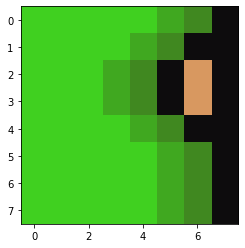

In [185]:
plt.imshow(get_sprite(15,8, h = 1, w = 1))
plt.show()

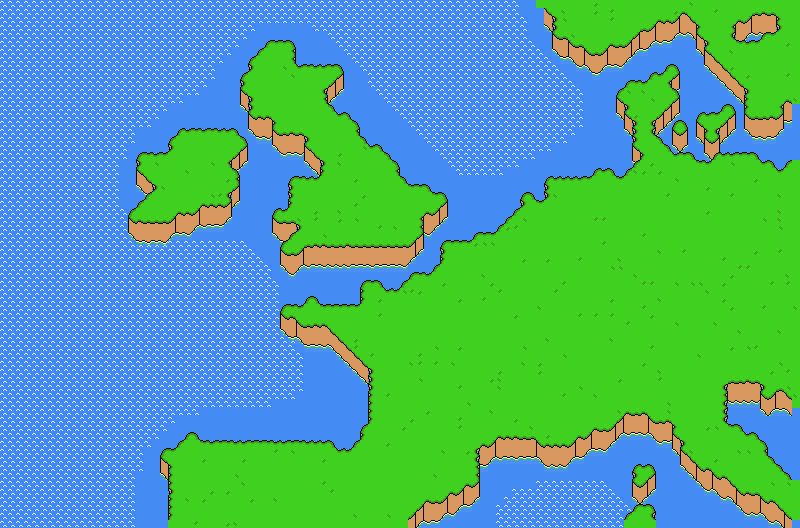

In [186]:
from scipy.ndimage import gaussian_filter as gf

dataPixPerTile = int(im.size[0]/tiles_x) #Very approx, avoid

canvas.paste((68,139,244),(0,0,canvas.size[0], canvas.size[1]))

DATA_WATER = 20
DATA_URBAN = 18

def t2x(tx): #Convert tile coords to map coords
    return int(tx * im.size[0]/tiles_x)
def t2y(ty):
    return int(ty * im.size[0]/tiles_x)

def rand_rot(im):
    n = random.choice([0,1,2,3])
    return im.rotate(90 * n)


            
def draw_grass(canvas, tx,ty):
    grass_sprites = [get_sprite(10,7), get_sprite(11,7)]
    s = random.choices(grass_sprites, [10,1])[0]
    s = rand_rot(s)
    draw_sprite(canvas, s,tx,ty)


#Get all tiles that are land
land = np.full((tiles_x, tiles_y), False)
for tx in range(tiles_x):
    for ty in range(tiles_y):
        d = data[t2x(tx):t2x(tx+1),t2y(ty):t2y(ty+1)]
        if (d == DATA_WATER).mean() < 0.5:
            land[tx,ty] = True
land = gf(land.astype(float), 0.7) > 0.5 #Smooth a lil
#Smooth more:
for tx in range(tiles_x):
    for ty in range(tiles_y):
        if land[tx,ty] == False: continue
        #At edge
        if tx == 0 or ty == 0 or tx == tiles_x - 1 or ty == tiles_y - 1:
            draw_grass(canvas, tx, ty)
            continue
        u = land[tx,ty - 1]
        d = land[tx,ty +1]
        l = land[tx -1, ty]
        r = land[tx + 1, ty]
        if (not (l or r)) or (not (u or d)):
            land[tx,ty] = 0 


    
#Make ocean pretty
land_gf = gf(land.astype(float), 5)
for tx in range(tiles_x):
    for ty in range(tiles_y):
        if land[tx,ty] == True: continue
        if land_gf[tx,ty] > 0.2: continue
        wave_sprites = [get_sprite(0,0),get_sprite(0,1),get_sprite(0,2)]
        s = wave_sprites[0]
        draw_sprite(canvas, s,tx,ty)
        


#Draw green ground
for tx in range(tiles_x):
    for ty in range(tiles_y):
        if land[tx,ty] == False: continue
        #At edge
        if tx == 0 or ty == 0 or tx == tiles_x - 1 or ty == tiles_y - 1:
            draw_grass(canvas, tx, ty)
            continue
        u = land[tx,ty - 1]
        d = land[tx,ty +1]
        l = land[tx -1, ty]
        r = land[tx + 1, ty]
        ul = land[tx -1, ty - 1]
        ur = land[tx +1, ty - 1]
        dl = land[tx -1, ty + 1]
        dr = land[tx +1, ty + 1]
        
        if not d:
            if l and r:
                #Horizontal continue
                draw_sprite(canvas, random.choice([get_sprite(11,11), get_sprite(12,11)]), tx, ty)
                draw_sprite(canvas, get_sprite(10,12), tx, ty+1)
                draw_sprite(canvas, get_sprite(10,12), tx, ty+2)
                draw_sprite(canvas, random.choice([get_sprite(11,15), get_sprite(12,15)]), tx, ty+3)
            elif l and not r:
                #Begin up right
                if dr and ul:
                    draw_sprite(canvas, get_sprite(16,10), tx, ty)
                    draw_sprite(canvas, get_sprite(10,12), tx, ty+1)
                else:
                    draw_sprite(canvas, get_sprite(15,10), tx, ty)
                    draw_sprite(canvas, get_sprite(12,12), tx, ty+1)
                draw_sprite(canvas, get_sprite(15,13), tx, ty+2)
            elif not l and r:
                #Begin up left
                if ul and dr:
                    draw_sprite(canvas, get_sprite(7,10), tx, ty)
                    draw_sprite(canvas, get_sprite(10,12), tx, ty+1)
                else:
                    draw_sprite(canvas, get_sprite(8,10), tx, ty)
                    draw_sprite(canvas, get_sprite(11,12), tx, ty+1)
                draw_sprite(canvas, get_sprite(8,13), tx, ty+2)
        #Side panels
        elif u and not r:
            draw_sprite(canvas, random.choice((get_sprite(15,9),get_sprite(15,8))), tx, ty)
        elif u and not l:
            draw_sprite(canvas, random.choice((get_sprite(8,9),get_sprite(8,8))), tx, ty)
        #Top panels
        elif d and not u:
            if l and r:
                #Horizontal continue
                draw_sprite(canvas, random.choice([get_sprite(11,6), get_sprite(12,6)]), tx, ty)
            elif l and not r:
                #Begin up right
                draw_sprite(canvas, get_sprite(15,7), tx, ty)
            elif  not l and r:
                #Begin up left
                draw_sprite(canvas, get_sprite(8,7), tx, ty)
            elif ul and l and not r:
                #Continue up right
                draw_sprite(canvas, get_sprite(16,10), tx, ty)
            elif ur and r and not l:
                #Continue up left
                draw_sprite(canvas, get_sprite(7,10), tx, ty)
            else:
                draw_grass(canvas, tx, ty)
        #Catch other shit, discard
        elif (not u) or (not d) or (not l) or (not r):
            land[tx,ty] = False
            continue
        else:
            draw_grass(canvas, tx, ty)
            
canvas_1 = canvas
canvas_1

### Now to add cities

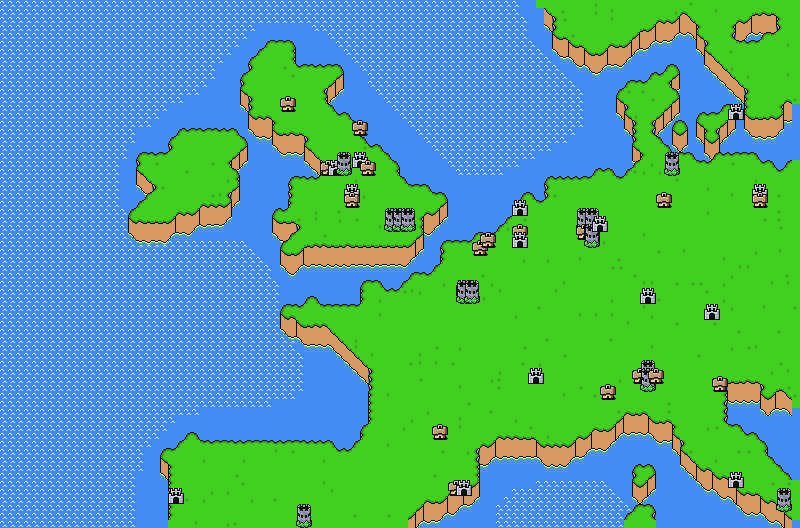

In [187]:
canvas = canvas_1.copy()

sprites_urban = [get_sprite_level(7,1), get_sprite_level(8,1), get_sprite_level(8,2)]
urban = np.full((tiles_x, tiles_y), False)
for tx in range(tiles_x):
    for ty in range(tiles_y):
        d = data[t2x(tx):t2x(tx+1),t2y(ty):t2y(ty+1)]
        urbanness = (d == DATA_URBAN).mean()
        if urbanness > 0.5:
            draw_sprite(canvas, get_sprite_level(7,1) , tx, ty-2 -1)
            draw_sprite(canvas, get_sprite_level(7,2) , tx, ty-1)
        elif urbanness > 0.4:
            draw_sprite(canvas, get_sprite_level(8,0) , tx, ty-1)
        elif urbanness > 0.3:
            draw_sprite(canvas, get_sprite_level(8,2) , tx, ty-1)
#         elif urbanness > 0.3:
#             draw_sprite(canvas, get_sprite_level(7,0) , tx, ty)
            
canvas
            


### Scratch that, that looks trash. Use population data instead.

In [188]:
path = glob.glob("map_data/*s.dbf")[0]
df = Dbf5(path).to_dataframe()
print(path)

map_data/ne_10m_populated_places.dbf


### But do that in a bit...

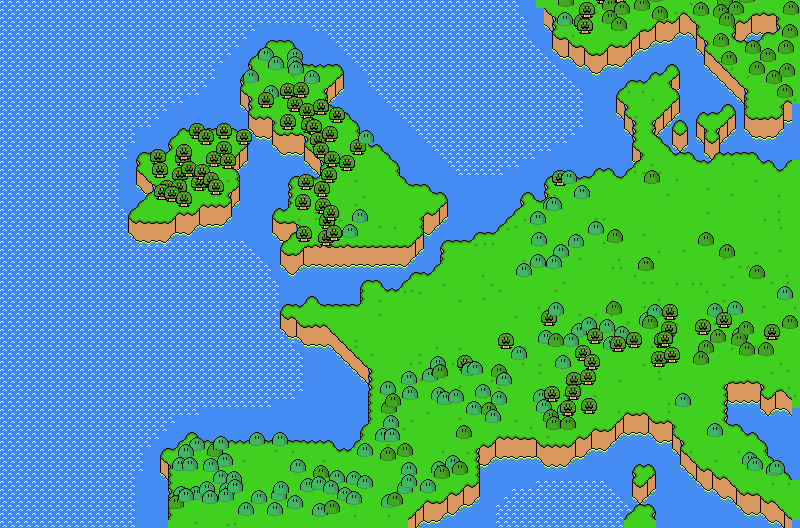

In [189]:
canvas = canvas_1.copy()

def near_sea(tx, ty, s = 1):
    tx = int(tx)
    ty = int(ty)
    l = land[tx-s:tx+s,ty-s:ty+s]
    return  np.any(np.logical_not(l))

for tx in range(tiles_x)[::2]:
    for ty in range(tiles_y)[::2]:
        d = data[t2x(tx):t2x(tx+1),t2y(ty):t2y(ty+1)]
        
        if (d == 8).mean() > 0.2: #Hervaceous: all over england
            s =  get_sprite(5,5, w = 2, h = 2)
        elif (d == 3).mean() > 0.2: #Needleleaf evergreen: all over america
            s =  get_sprite(23,16, w = 2, h = 2)
        elif (d == 6).mean() > 0.1: #Want it to be hotter trees, need sprite. 3 is spain
            s =  get_sprite(23,14, w = 2, h = 2)
        else:
            continue
        x = tx + 1*(2 * random.random() - 1)
        y = ty + 1*(2 * random.random() - 1)
        if near_sea(x,y): continue
        draw_sprite(canvas, s, x-1, y-2)

canvas2 = canvas
canvas

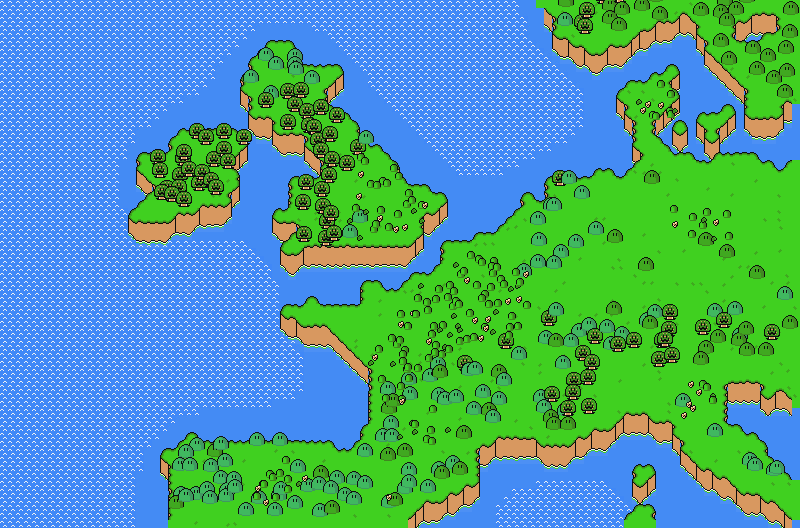

In [196]:
canvas = canvas2.copy()




#Get all tiles that are crops
crops = np.full((tiles_x, tiles_y), False)
for tx in range(tiles_x):
    for ty in range(tiles_y):
        d = data[t2x(tx):t2x(tx+1),t2y(ty):t2y(ty+1)]
        if (d == 11).mean() > 0.6:
            crops[tx,ty] = True
crops = gf(crops.astype(float), 2) > 0.3 #Smooth a lil
#Smooth more:
for tx in range(tiles_x):
    for ty in range(tiles_y):
        if crops[tx,ty] == False: continue
        #At edge
        if tx == 0 or ty == 0 or tx == tiles_x - 1 or ty == tiles_y - 1:
            draw_grass(canvas, tx, ty)
            continue
        u = land[tx,ty - 1]
        d = land[tx,ty +1]
        l = land[tx -1, ty]
        r = land[tx + 1, ty]
        if (not (l or r)) or (not (u or d)):
            crops[tx,ty] = 0 
            
crop_sprites = [get_sprite(14,9), get_sprite(14,8), get_sprite(9,9)]
for tx in range(tiles_x)[::1]:
    for ty in range(tiles_y)[::1]:
        d = data[t2x(tx):t2x(tx+1),t2y(ty):t2y(ty+1)]
        if crops[tx,ty]:
            s =  random.choices(crop_sprites, [1,1,4])[0]
        else:
            continue
        if random.random() > 0.4: continue
        x = tx + .5*(2 * random.random() - 1)
        y = ty + .5*(2 * random.random() - 1)
        if near_sea(x,y): continue
        draw_sprite(canvas, s, x, y)
        
canvas3 = canvas
canvas

In [268]:
path = glob.glob("map_data/*s.dbf")[0]
df = Dbf5(path).to_dataframe()

df = df[df.LATITUDE > lat_bottom]
df = df[df.LATITUDE < lat_top]
df = df[df.LONGITUDE > lon_left]
df = df[df.LONGITUDE < lon_right]
df = df[df.RANK_MAX > 8]

df["tx"] = (df['LONGITUDE'] - lon_left)/(lon_right - lon_left) * tiles_x
df["ty"] = tiles_y - (df['LATITUDE'] - lat_bottom)/(lat_top - lat_bottom) * tiles_y


df_ = df[["NAME","POP_MAX","RANK_MAX", "tx", "ty"]].sort_values(by = "POP_MAX")[-30:]

In [252]:
np_df = df_.to_numpy()
np_df

array([['Glasgow', 1160000, 12, 35.830975879566665, 13.614464413439997],
       ['Prague', 1162000, 12, 98.21993258566667, 32.72498785082999],
       ['Düsseldorf', 1220000, 12, 72.59996323863334, 28.97276726981999],
       ['Geneva', 1240000, 12, 70.46676011363334, 45.50697509457001],
       ['Munich', 1275000, 12, 88.58331149166666, 39.171191281199995],
       ['Duisburg', 1276757, 12, 72.50005546956668, 28.281088558799993],
       ['Sheffield', 1292900, 12, 45.0000113885, 21.889967037839995],
       ['Porto', 1337000, 12, 21.2666624572, 62.20497912287999],
       ['Marseille', 1400000, 12, 67.9167004348, 55.1430690888],
       ['The Hague', 1406000, 12, 64.23320434103333, 26.135878414800004],
       ['Lyon', 1423000, 12, 66.10010158496667, 46.95897173781],
       ['Florence', 1500000, 12, 87.500001216, 53.52599725044],
       ['Leeds', 1529000, 12, 44.733274870466666, 20.360975094569994],
       ['Turin', 1652000, 12, 75.56653496176668, 49.26772228719],
       ['Essen', 1742135, 12,

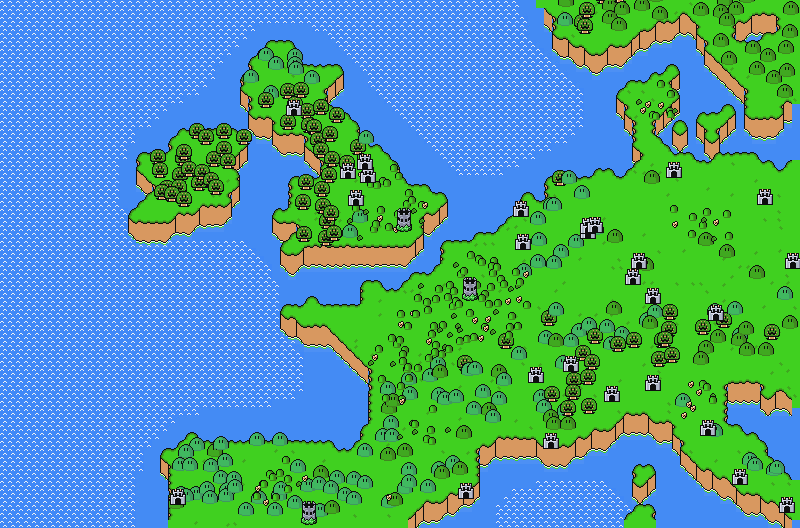

In [267]:
canvas = canvas3.copy()


for i in range(np_df.shape[0]):
    d = np_df[i]
    rank, tx, ty = d[2:5]
    if rank == 13:
        draw_sprite(canvas, get_sprite_level(7,1) , tx, ty-2 -1)
        draw_sprite(canvas, get_sprite_level(7,2) , tx, ty-1)
    elif rank == 12:
        draw_sprite(canvas, get_sprite_level(8,0) , tx, ty-1)
    else:
        draw_sprite(canvas, get_sprite_level(8,2) , tx, ty-1)

    
canvas

In [ ]:
df_.head()